In [1]:
# This file is a modified version of the original:
# https://www.kaggle.com/code/paulbacher/detailed-eda-student-perf-from-game-play

# 🎓[Detailed EDA] Predict Student Performance from Game Play
---
This competition organized by [The Learning Agency Lab](https://www.kaggle.com/competitions/predict-student-performance-from-game-play) aims to predict the **performance of students while playing an educational game**. The data available to train a model is a large game log. The development of such a tool will assist developers in creating a more effective learning experience for students. The objective of this competition is to use time series data generated by an online educational game to determine whether players will answer questions correctly.

The peculiarities of this competition are the imposed constraints:
- The virtual machine only has 2 cores and 8GB of RAM
- The use of GPU is prohibited.


# ✈️ Let's get started
We need to predict whether each student answered each question correctly, which involves binary classification for each question in each student session.

## Competition metric
The evaluation metric is the F1-score, which is a common metric used for classification tasks. Its formula is as follow:

$$ F_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} $$
Where,
$$ precision = \frac{TP}{TP + FP} \hspace{1cm} recall = \frac{TP}{TP + FN} $$

## Efficiency prize
The efficiency prize combines both the F1-score and runtime. Just because a model has the highest leaderboard score, it doesn't necessarily mean it's the best in the real world. For example, a more accurate model may take days to run, while a less accurate one could run in a fraction of seconds. In such cases, which model is the best depends on a trade-off between accuracy and efficiency. The efficiency score is computed using the following formula:

Benchmark is the score of the benchmark `sample_submission.csv` and maxF1 is the best LB score.

\begin{equation}
Efficiency = \frac{1}{Benchmark - maxF1}.F1 + \frac{1}{32400}.RuntimeSeconds
\end{equation}



## Data
The primary components of the data package are various CSV files. There is the standard `sample_submission.csv` file, which provides an example of the required submission format. Additionally, there are the `train.csv` and `test.csv` sets, as well as a separate file that contains labels for the training set. There is also a folder named `jo_wilder` that sets up the new environment.

|No  | Columns name |  Meaning |
|:---| :---         |:---      |
| 1  | <font color="#254441"> session_id </font>  |  the ID of the session the event took place in |
| 2  | <font color="#254441"> index </font>  |  the index of the event for the session |
| 3  | <font color="#254441"> elapsed_time </font>  |  how much time has passed (in milliseconds) between the start of the session <br>and when the event was recorded  |
| 4  | <font color="#254441"> event_name </font>  | the name of the event type  |
| 5  | <font color="#254441"> name </font>  |  the event name (e.g. identifies whether a notebook_click is is opening<br> or closing the notebook) |
| 6  | <font color="#254441"> level </font>  |  what level of the game the event occurred in (0 to 22)  |
| 7  | <font color="#254441"> page </font>  |   the page number of the event (only for notebook-related events) |
| 8  | <font color="#254441"> room_coor_x </font>  | the coordinates of the click in reference to the in-game room (only for click events)  |
| 9  | <font color="#254441"> room_coor_y </font>  |  the coordinates of the click in reference to the in-game room (only for click events) |
| 10  | <font color="#254441"> screen_coor_x </font>  | the coordinates of the click in reference to the player’s screen (only for click events)  |
| 11  | <font color="#254441"> screen_coor_y </font>  |  the coordinates of the click in reference to the player’s screen (only for click events) |
| 12  | <font color="#254441"> hover_duration </font>  |  how long (in milliseconds) the hover happened for (only for hover events) |
| 13  | <font color="#254441"> text </font>  | the text the player sees during this event  |
| 14  | <font color="#254441"> fqid  </font>  | the fully qualified ID of the event  |
| 15  | <font color="#254441"> room_fqid  </font>  | the fully qualified ID of the room the event took place in  |
| 16 | <font color="#254441">  text_fqid </font>  |  the fully qualified ID of the  |
| 17  | <font color="#254441">  fullscreen  </font>  |  whether the player is in fullscreen mode |
| 18  | <font color="#254441">  hq  </font>  |  whether the game is in high-quality |
| 19  | <font color="#254441">  music </font>  |   whether the game music is on or off |
| 20  | <font color="#254441"> level_group  </font>  | which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)  |


# 🛠️ Imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# 💾 Read the files
We load the csv files with pandas.

In [3]:
PATH = '/kaggle/input/predict-student-performance-from-game-play'

train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')
labels_df = pd.read_csv(f'{PATH}/train_labels.csv')
submission_df = pd.read_csv(f'{PATH}/sample_submission.csv')

# 👁️ Exploring the data
Let's look at the dimensions of the train and test dataframes. We also display the first 2 rows of the train set.

In [4]:
print("Train: rows", len(train_df), "| columns", len(train_df.columns))
print("Test:  rows    ", len(test_df), "| columns", len(test_df.columns))

train_df.head(2)

Train: rows 26296946 | columns 20
Test:  rows     3728 | columns 21


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


#### - Insights
- It is quite a big dataframe (the train.csv file is more than 2GB large). It has more than 13 millions rows and a few features.
- The test dataframe has an extra columns called `session_level` which will be used to create the submission file.

Let's see if all features are relevant by analysing them.
## 💡 Missing values

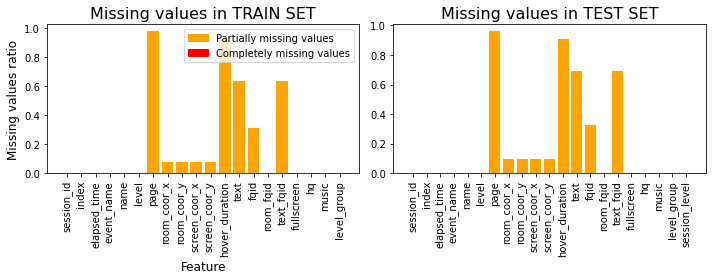

In [5]:
train_missing_ratios = train_df.isna().sum() / len(train_df)
test_missing_ratios = test_df.isna().sum() / len(test_df)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(train_missing_ratios.index,
        train_missing_ratios.values,
        color=['red' if ratio == 1 else 'orange' for ratio in train_missing_ratios.values])
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Missing values ratio', fontsize=12)
plt.title('Missing values in TRAIN SET', fontsize=16)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partially missing values', 'Completely missing values'])

plt.subplot(1, 2, 2)
plt.bar(test_missing_ratios.index,
        test_missing_ratios.values,
        color=['red' if ratio == 1 else 'orange' for ratio in test_missing_ratios.values])
plt.title('Missing values in TEST SET', fontsize=16)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### - Insights
- There are a lot of missing values in some columns.
- We will drop the `fullscreen`, `hq` and `music` features at least, and maybe the ones with more than 80% of missing values. To make this decision about keeping or not the columns with high missing ratio, we will have to evaluate the relevance of them.
- The train and test dataframes have similar ratios of missing values which are good news.

## 💡 Analysis of the features
Let's analyse all the features in order to understand what they mean.
### 'Session id' and 'index'
> The ID of the session the event took place in

> The index of the event for the session

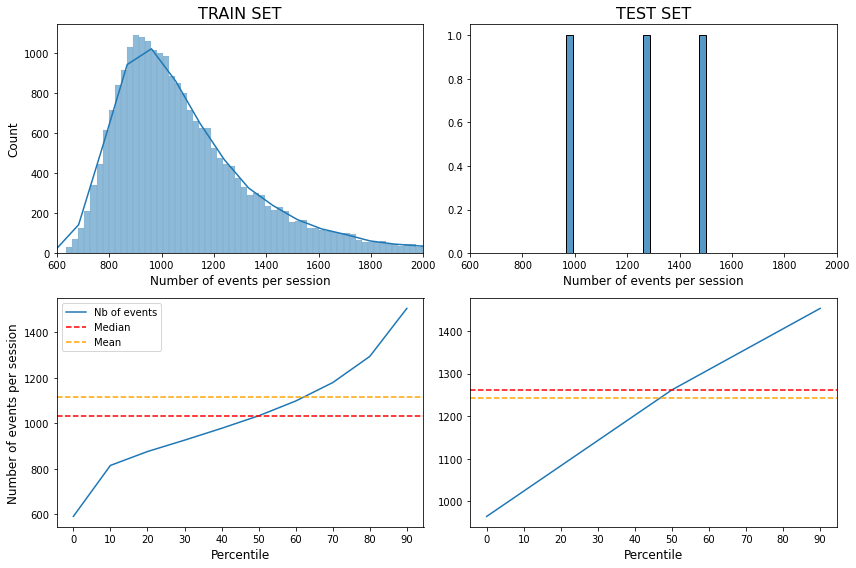

,TRAIN,TEST
Index,,
Nb of sessions,23562,3
Min nb of events,591,965
Max nb of events,19032,1501


In [6]:
train_events_per_session = train_df['session_id'].value_counts()
test_events_per_session = test_df['session_id'].value_counts()

train_percentiles, test_percentiles = [], []
xrange = range(0, 100, 10)
for q in xrange:
    train_perc = np.percentile(train_events_per_session, q)
    test_perc = np.percentile(test_events_per_session, q)
    train_percentiles.append(train_perc)
    test_percentiles.append(test_perc)
    
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(train_events_per_session.values, kde=True)
plt.xlabel("Number of events per session", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("TRAIN SET", fontsize=16)
plt.xlim(600, 2000)

plt.subplot(2, 2, 2)
sns.histplot(test_events_per_session.values, bins=20)
plt.xlabel("Number of events per session", fontsize=12), plt.ylabel("")
plt.title("TEST SET", fontsize=16)
plt.xlim(600, 2000)

plt.subplot(2, 2, 3)
plt.plot(xrange, train_percentiles)
plt.axhline(train_events_per_session.median(), color='red', ls='--')
plt.axhline(train_events_per_session.mean(), color='orange', ls='--')
plt.xlabel("Percentile", fontsize=12)
plt.ylabel("Number of events per session", fontsize=12)
plt.xticks(xrange)
plt.legend(['Nb of events', 'Median', 'Mean'])

plt.subplot(2, 2, 4)
plt.plot(xrange, test_percentiles)
plt.axhline(test_events_per_session.median(), color='red', ls='--')
plt.axhline(test_events_per_session.mean(), color='orange', ls='--')
plt.xlabel("Percentile", fontsize=12)
plt.xticks(xrange)

plt.tight_layout()
plt.show()

data = {"Index": ["Nb of sessions", "Min nb of events", "Max nb of events"],
        "TRAIN": [str(train_df['session_id'].nunique()),
                  str(train_events_per_session.min()),
                  str(train_events_per_session.max())],
        "TEST": [str(test_df['session_id'].nunique()),
                 str(test_events_per_session.min()),
                 str(test_events_per_session.max())]}
df = pd.DataFrame(data).set_index('Index')
df

#### - Insights
- **Train set:**
 - A session typically encompasses anywhere between several hundred to a few thousand individual events.
 - Both the median and the mean are slightly over 1000.
 - The distribution appears to be normal with a slight positive skew.
 - Above the 90th percentile, the values for the number of events are very large. I set a x limit for visualization but the number of events go very far. Should we consider them as outliers?
- **Test set:**
 - Only 3 sessions are represented in the test set having a fair amount of events.
 - The session with 1501 events is in the tail of the gaussian distribution but still in a reasonable area.
 - Do not forget that the available test set only represents the half of the final one.
- **Events vs Level:**
 - Currently, we have only analyzed the number of events that occur during the sessions.
 - Keep in mind that a session is divided into question levels, and we aim to predict their success. However, the number of events can vary for each question level. It's possible that the number of actions (clicks) during a question may be related to a correct or incorrect answer. It would be interesting to inspect that later.
 
### 'Elapsed time' and 'index'
> How much time has passed (in milliseconds) between the start of the session and when the event was recorded.

The elapsed time should be correlated with the event index. As more time is spent, it is expected that a higher number of events will occur. This is why I have decided to calculate the mean for each event index and plot it.

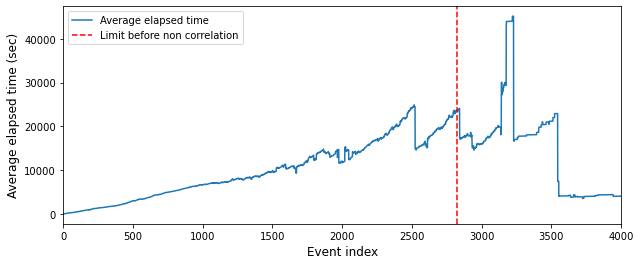

In [7]:
# Average the elapsed time in seconds for each index
avg_elapsed_time = train_df.groupby('index')['elapsed_time'].mean() / 1000

plt.figure(figsize=(10, 4))
plt.plot(avg_elapsed_time)
plt.axvline(2825, color='red', ls='--')
plt.xlabel("Event index", fontsize=12)
plt.ylabel("Average elapsed time (sec)", fontsize=12)
plt.xlim([0, 4000])
plt.legend(['Average elapsed time', 'Limit before non correlation'])

plt.show()

#### - Insights
- As expected, the average elapsed time increases with the increase in event index, but this trend only holds until around index 2800. After that, the behavior becomes erratic with a peak and then drops and remains constant until much later.
- This phenomenon can be explained by the fact that as the number of events increases, there are fewer and fewer examples, and the average starts to represent unique cases which are likely outliers. These outliers may include individuals who did "spam clicks" to achieve a high number of events in a shorter amount of time or, in the case of the peak, individuals who were inactive for an extended period.

Let's now check the elapsed times for individual cases and see if this trend remains the same.

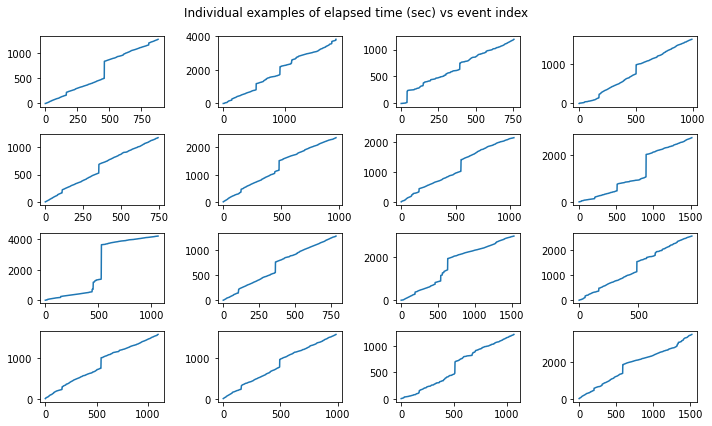

In [8]:
# Get the sessions in the dataframe
session_ids = np.array(train_df['session_id'].unique())

plt.figure(figsize=(10, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    times = train_df[train_df['session_id'] == session_ids[i]]['elapsed_time']
    plt.plot(times.reset_index(drop=True) / 1000)
plt.suptitle("Individual examples of elapsed time (sec) vs event index")
plt.tight_layout()
#plt.show()   

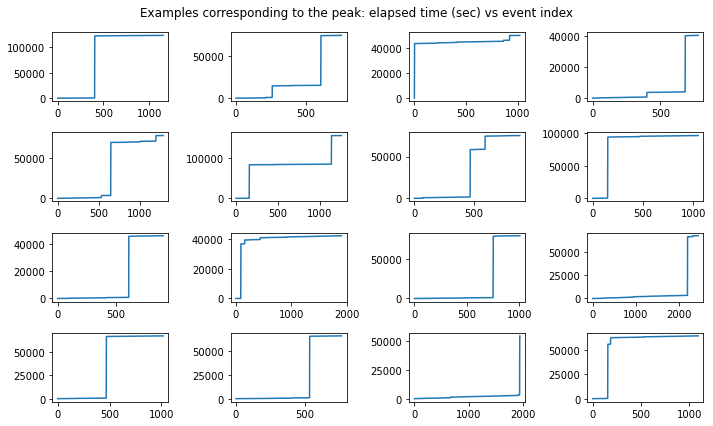

In [9]:
# Get the session ids corresponding to the peak
peak_session_ids = train_df[train_df['elapsed_time'] > 4e7]['session_id'].unique()

plt.figure(figsize=(10, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    times = train_df[train_df['session_id'] == peak_session_ids[i]]['elapsed_time']
    plt.plot(times.reset_index(drop=True) / 1000)
plt.suptitle("Examples corresponding to the peak: elapsed time (sec) vs event index")
plt.tight_layout()
plt.show()

In [10]:
print("The longest session  of the TRAIN SET lasted about",
      int(train_df['elapsed_time'].max() / 8.64e7), "days.")
print("The longest session of the TEST SET lasted about",
      int(test_df['elapsed_time'].max() / 1000), "sec.")

The longest session  of the TRAIN SET lasted about 23 days.
The longest session of the TEST SET lasted about 6524 sec.


#### - Insights
- Almost all of the examples shown exhibit gaps, indicating brief pauses in activity.
- Some examples, however, exhibit huge gaps due to extended periods of inactivity.
- The maximum elapsed time in the test set appears to be more reasonable than the outliers observed in the training set. It may be beneficial to get rid of sessions in which the individual was inactive for an extended period of time.

### 'Event name' and 'name'
> The name of the event type.

> The event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)

These 2 columns are quite similar since they describe the action of the user. Let's display there distributions independently and in a pivot table. The data are from the train set.

Meaning of the event_name:

* navigate_click: click on the place we want protagonist (he/she) to move;
* observation_click: when you take your mouse pointer close to certain observations, a text appears near to the observation. The click you make just after the text appears is an observation_click.;
* notification_click: If you navigate click on an object like the notebook, the retirement letter, the slip on the shirt, etc, the object pops up and a text appears at the bottom of the object. The click after the text appears, to hide or to continue is a notification_click;
* object_click:  after notification_click, any click anywhere on the object pop up or a click on the cross to close the object pop up is an object_click.;
* object_hover: when we take the mouse pointer above the task object or next/previous buttons, our mouse pointer's design changes (to hand) and object_hover duration starts getting recorded; 
* map_hover: just like object_hover, when you takes the pointer above any place in the map_hover duration starts getting recorded;
* map_click: click on a place on the map to go there;
* notebook_click: click on notebook to look for notes made by he/she. Clicking on the notebook to open it, clicking on any page of the notebook, clicking on next or previous button and closing the notebook, all are notebook_clicks.;
* checkpoint: checkpoint is the last event of a level-group/chapter in the data. <b>The questions that we have to predict are asked after this point in the game.</b>

Number of event names: 11
Number of names: 6


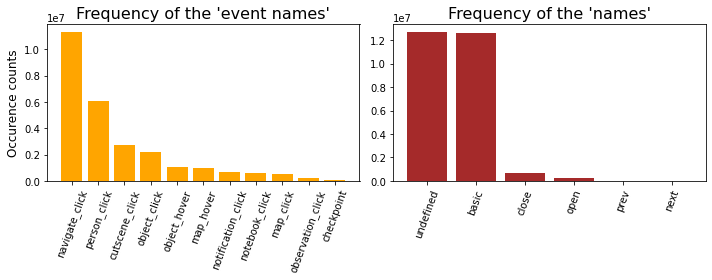

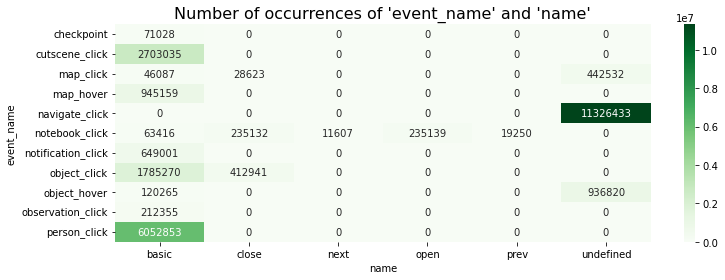

In [11]:
event_names = train_df['event_name'].value_counts()
names = train_df['name'].value_counts()

print("Number of event names:", len(event_names))
print("Number of names:", len(names))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(event_names.index, event_names.values, color='orange')
plt.ylabel("Occurence counts", fontsize=12)
plt.title("Frequency of the 'event names'", fontsize=16)
plt.xticks(rotation=70)

plt.subplot(1, 2, 2)
plt.bar(names.index, names.values, color='brown')
plt.title("Frequency of the 'names'", fontsize=16)
plt.xticks(rotation=70)

plt.tight_layout()
plt.show()

# Pivot table
pivot_table = train_df.pivot_table(index='event_name', columns='name', aggfunc='size')
pivot_table = pivot_table.fillna(0).astype(int)
plt.figure(figsize=(12, 4))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Greens')
plt.title("Number of occurrences of 'event_name' and 'name'", fontsize=16)
plt.show()

#### - Insights
- The events mainly consist of clicks and occasionally hovers. I am uncertain about the distinction between the various types of clicks.
- Certain "names" only occur with specific "event_names". Not all combinations are possible.
- I have also checked the distribution in the test set, and it is comparable to the distribution in the training set.

### 'Index' and 'level'
> What level of the game the event occurred in (0 to 22)

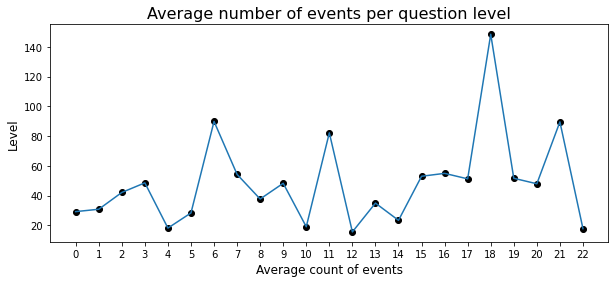

In [12]:
# Nb of events averaged per question
grouped_df = train_df.groupby(['session_id', 'level'])\
    ['index'].count().reset_index()
grouped_df.columns = ['session_id', 'level', 'index_count']
mean_counts = grouped_df.groupby('level').mean().drop('session_id', axis=1)
mean_counts

xrange = range(0, 23)
plt.figure(figsize=(10, 4))
plt.plot(mean_counts)
plt.scatter(xrange, mean_counts, color='black')
plt.title("Average number of events per question level", fontsize=16)
plt.xlabel("Average count of events", fontsize=12)
plt.ylabel("Level", fontsize=12)
plt.xticks(xrange)
plt.show()

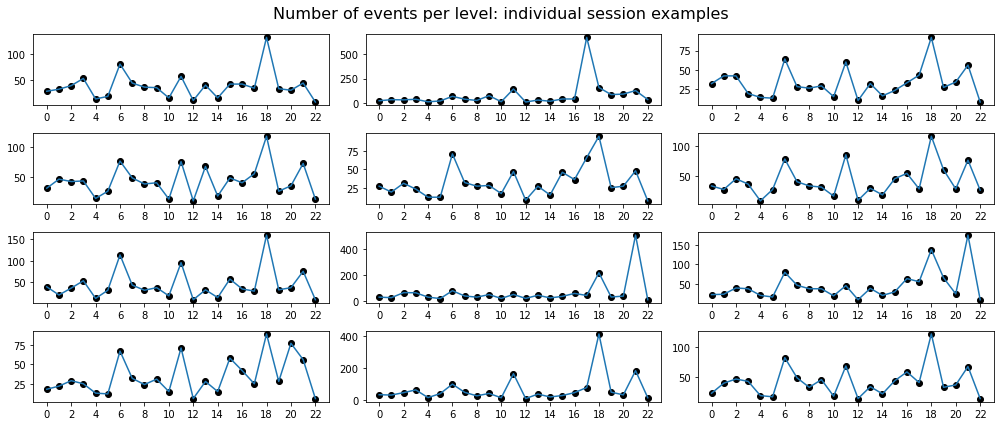

In [13]:
# Plot a few individual examples
plt.figure(figsize=(14, 6))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    example = grouped_df[
        grouped_df['session_id'] == session_ids[i]]\
        ['index_count'].reset_index(drop=True)
    plt.plot(example)
    plt.scatter(range(0, 23), example, color='black')
    plt.xticks(range(0, 23, 2))
plt.suptitle("Number of events per level: individual session examples",
             fontsize=16)
plt.tight_layout()
plt.show()

#### - Insights
- A greater number of events take place during specific periods. For instance, there is a heightened level of event activity observed at level 18.
- This pattern can also be observed in various individual cases as examples. However, each one remains unique.

### 'Page'
>  The page number of the event (only for notebook-related events)

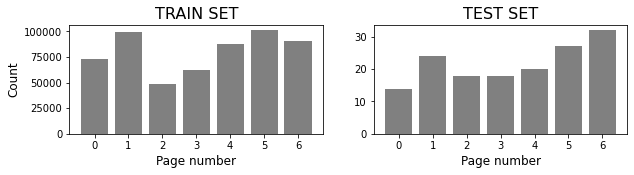

In [14]:
train_page_number_counts = train_df['page'].value_counts().sort_index()
test_page_number_counts = test_df['page'].value_counts().sort_index()
plt.figure(figsize=(10, 2))

plt.subplot(1, 2, 1)
plt.bar(range(0, 7), train_page_number_counts, color='gray')
plt.xlabel("Page number", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("TRAIN SET",
          fontsize=16)

plt.subplot(1, 2, 2)
plt.bar(range(0, 7), test_page_number_counts, color='gray')
plt.xlabel("Page number", fontsize=12)
plt.title("TEST SET",
          fontsize=16)

plt.show()

#### - Insights
- A lot of values are still missing in this columns (almost 98%) because a page is only indicated when the event is notebook-related.
- I don't know if this information is relevant or not. Is it worth it to keep it and how should we fill in the missing values? With zeros?
- The test set has a slightly different distribution from the train set for the page number.

### 'Hover duration'
> How long (in milliseconds) the hover happened for (only for hover events)

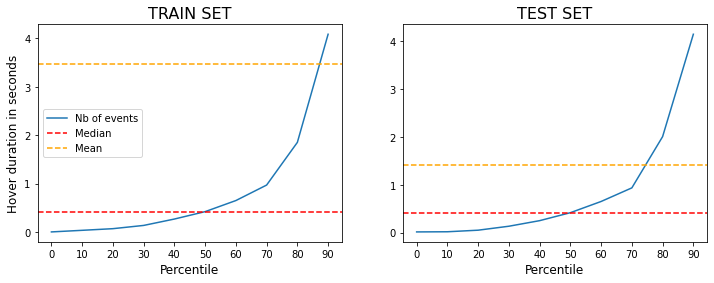

In [15]:
train_hover_durations = train_df['hover_duration'].dropna() / 1000
test_hover_durations = test_df['hover_duration'].dropna() / 1000

xrange = range(0, 100, 10)
train_percentiles , test_percentiles = [], []
for q in xrange:
    train_perc = np.percentile(train_hover_durations, q)
    test_perc = np.percentile(test_hover_durations, q)
    train_percentiles.append(train_perc)
    test_percentiles.append(test_perc)
    
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(xrange, train_percentiles)
plt.axhline(train_hover_durations.median(), color='red', ls='--')
plt.axhline(train_hover_durations.mean(), color='orange', ls='--')
plt.xticks(xrange)
plt.yticks(range(0, 5))
plt.legend(['Nb of events', 'Median', 'Mean'])
plt.xlabel("Percentile", fontsize=12)
plt.ylabel("Hover duration in seconds", fontsize=12)
plt.title("TRAIN SET", fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(xrange, test_percentiles)
plt.axhline(test_hover_durations.median(), color='red', ls='--')
plt.axhline(test_hover_durations.mean(), color='orange', ls='--')
plt.xticks(xrange)
plt.xlabel("Percentile", fontsize=12)
plt.title("TEST SET", fontsize=16)

plt.show()

#### - Insights
- Similar to the page feature, the hover duration is indicated only for a few rows during an hover event. Typically, the duration lasts anywhere from a few milliseconds to a few seconds, with rare instances lasting more than 4 seconds.
- In the training set, we can observe that the mean is significantly higher than the median, which is due to the presence of outliers where the user remained on hover for an extended period. This type of examples should be avoided.

### 'Text'
> The text the player sees during this event

In [16]:
train_texts = train_df['text'].dropna().value_counts()
test_texts = test_df['text'].dropna().value_counts()
print("TRAIN | nb of unique texts:", len(train_texts))
print('-' * 60)
print(train_texts, '\n')
print("TEST | nb of unique texts:", len(test_texts))
print('-' * 60)
print(test_texts, '\n')

TRAIN | nb of unique texts: 597
------------------------------------------------------------
undefined                                      355969
\u00f0\u0178\u02dc\u0090                        48805
Hey!                                            47452
I should go to the Capitol and tell Mrs. M!     40463
This is perfect for the exhibit.                40218
                                                ...  
Sorry I'm late.                                     1
He needs our help!                                  1
Now can I tell you what happened to Teddy?          1
I knew you could do it, Jo!                         1
AND he stole Teddy!                                 1
Name: text, Length: 597, dtype: int64 

TEST | nb of unique texts: 495
------------------------------------------------------------
undefined                                     27
You can talk to a textile expert there.        7
Hey!                                           6
Can you help me tidy up?          

#### - Insights
- There are many different phrases from the game and some are more common than others.
- Some text is in ASCII unicode hex format, such as '\u00f0\u0178\u02dc\u0090'.
- It may be useful to process these texts in order to generate additional features from them.

### 'Fqid', 'room_fqid' and 'text_fqid'
> The fully qualified ID of the event

> The fully qualified ID of the room the event took place in

> The fully qualified ID of the text

In [17]:
# Count values
train_fqids = train_df['fqid'].value_counts()
train_room_fqids = train_df['room_fqid'].value_counts()
train_text_fqids = train_df['text_fqid'].value_counts()
test_fqids = test_df['fqid'].value_counts()
test_room_fqids = test_df['room_fqid'].value_counts()
test_text_fqids = test_df['text_fqid'].value_counts()
train_fqid_bundle = [train_fqids, train_room_fqids, train_text_fqids]
test_fqid_bundle = [test_fqids, test_room_fqids, test_text_fqids]
fqid_labels = ["fqid", "room_fqid", "text_fqid"]

# Display the unique values
def print_fqids(set_name, bundle):
    for label, value in zip(fqid_labels, bundle):
        print('-' * 60)
        print(set_name, label)
        print('-' * 60)
        print(value)  
print_fqids('TRAIN', train_fqid_bundle)
print_fqids('TEST', test_fqid_bundle)

# Number of unique values recap table
data = {"Nb unique values": fqid_labels,
        "TRAIN": [len(x) for x in train_fqid_bundle],
        "TEST": [len(x) for x in test_fqid_bundle]}
df = pd.DataFrame(data).set_index('Nb unique values')
df

------------------------------------------------------------
TRAIN fqid
------------------------------------------------------------
worker           1878958
archivist        1127341
gramps           1122264
wells             787418
toentry           784496
                  ...   
need_glasses        1297
block_badge_2        993
fox                  465
block_1               37
chap2_finale           1
Name: fqid, Length: 128, dtype: int64
------------------------------------------------------------
TRAIN room_fqid
------------------------------------------------------------
tunic.historicalsociety.entry              3622003
tunic.wildlife.center                      3013154
tunic.historicalsociety.cage               2352083
tunic.library.frontdesk                    2145666
tunic.historicalsociety.frontdesk          1943066
tunic.historicalsociety.stacks             1794007
tunic.historicalsociety.closet_dirty       1568994
tunic.humanecology.frontdesk               1326890
tunic.hi

,TRAIN,TEST
Nb unique values,,
fqid,128,112
room_fqid,19,19
text_fqid,126,91


#### - Insights
- These three features provide information about the player's conversation partner, the player's location in the game during the action, and the text identifier.
- The 'Fqid' appears to be the identifier of the person or object the player is interacting with, or something more abstract. There are slightly more of these values in the training set.
- The 'room_fqid' is composed of three words separated by periods. There are no missing values in this column, and there are 19 rooms in the game. Both the training and test sets include all of the rooms. I believe that this feature will be very useful for the model once it has been one-hot encoded. It is also possible to create new features from it by decomposing the string.
- The 'text_fqid' feature seems to combine the 'room_fqid' and the 'fqid' and add additional information about the text itself. It may be possible to extract the last part of this text to create a new feature.


### 'Room Click EDA'

The image below is screenshot from playing the game. The game has 19 rooms. (Many room image below required taking multiple screen shots and stitching them together with PhotoShop because the web browser does not show the entire room at once). The plots with dots are where the 11k train users click inside these rooms. For each room, we display scatter plots where users navigate_click and where users person_click. We then use the column fqid to add names to areas of interest in the scatter plots. 

More images view at: https://www.kaggle.com/code/cdeotte/game-room-click-eda

In [8]:
from PIL import Image

In [6]:
ROOMS = train_df.room_fqid.unique()
print('Number of rooms:', len(ROOMS) )
# print( ROOMS )

Number of rooms: 19




#########################
### ROOM 1: tunic.historicalsociety.closet
#########################


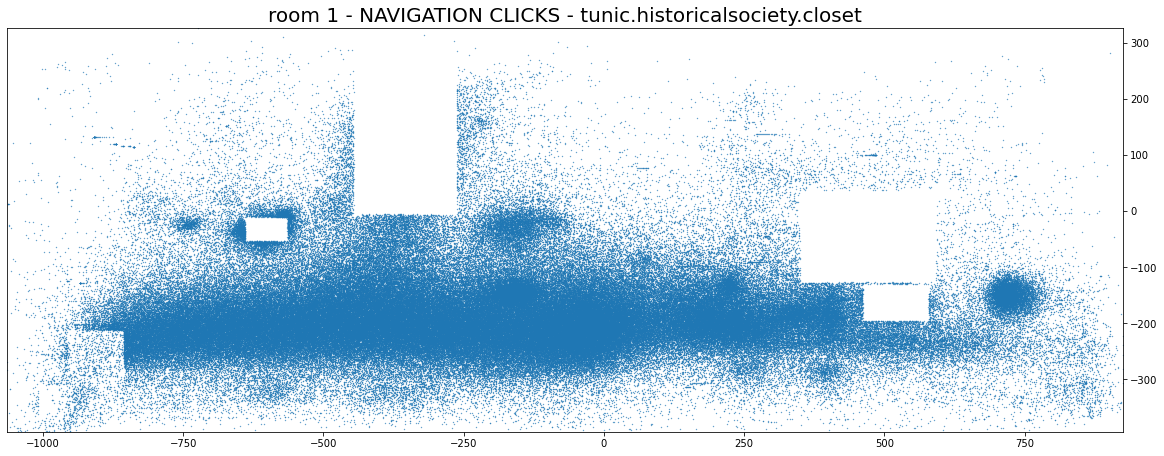

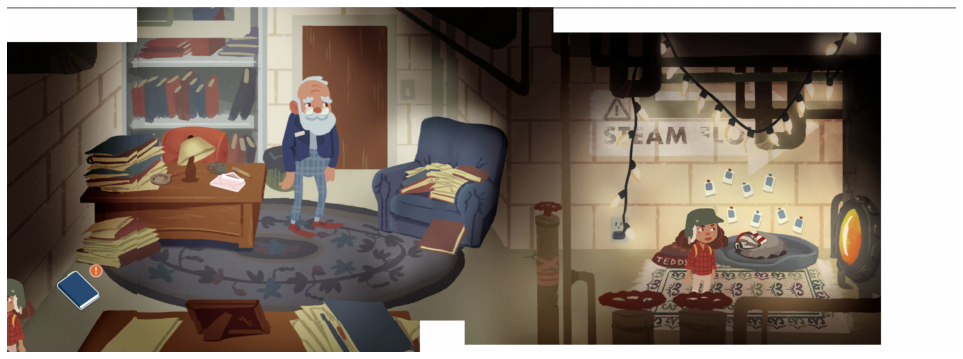

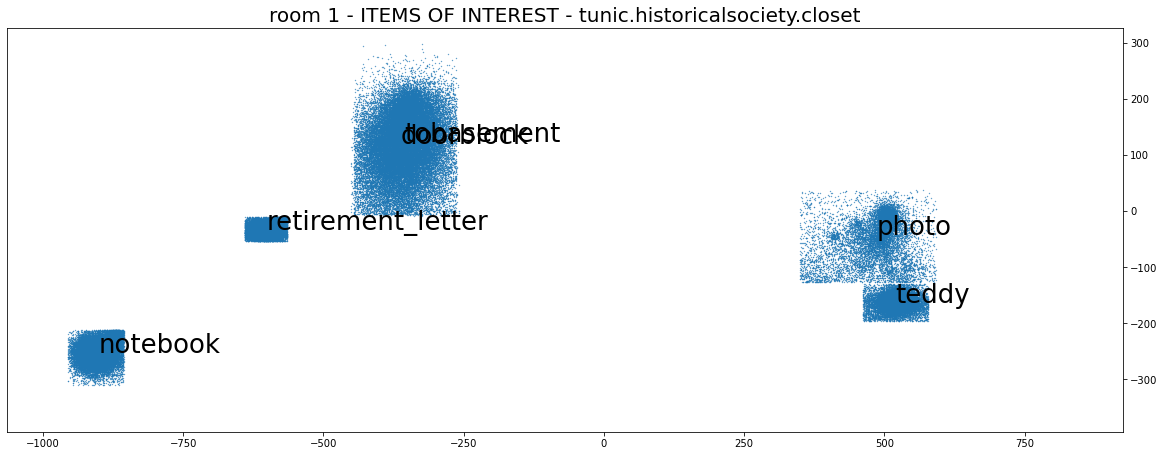

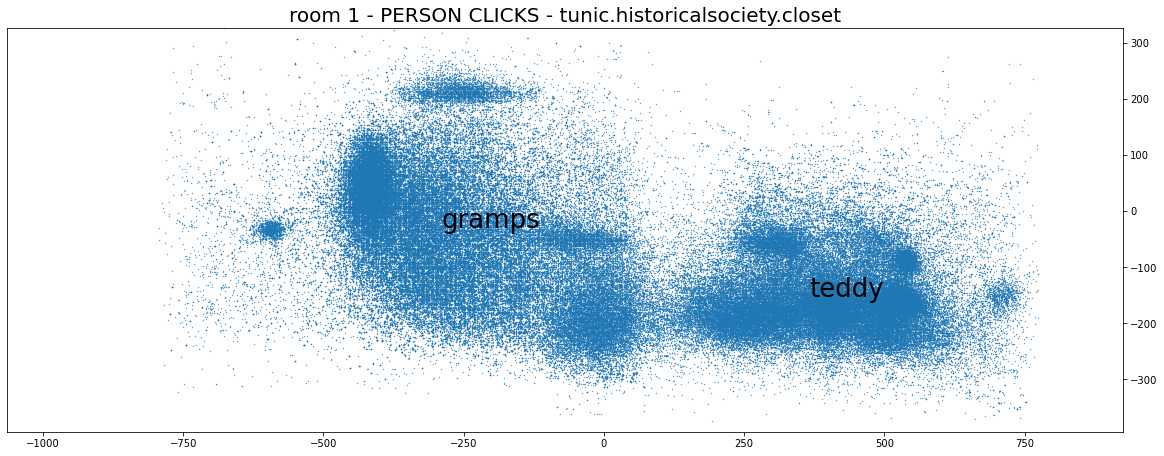

In [10]:
# DICTIONARY TO IMAGE PATHS
dd = {}
PATH = '/kaggle/input/kaggle-game-images/'
dd['tunic.historicalsociety.closet'] = Image.open(PATH+'closet.png')


# ITERATE ROOMS AND DISPLAY IMAGES AND SCATTER PLOTS
for j,rm in enumerate(ROOMS[:1]): # ROOMS
    print('\n')
    print('#'*25)
    print(f'### ROOM {j+1}:',rm)
    print('#'*25)
    
    # DISPLAY NAVIGATION CLICKS
    df = train_df.loc[(train_df.event_name=='navigate_click')
                   &(train_df.room_fqid==rm)&(train_df.fqid.isna())]
    x_min,y_min = df[['room_coor_x','room_coor_y']].min().values
    x_max,y_max = df[['room_coor_x','room_coor_y']].max().values
    plt.figure(figsize=(20,20))
    plt.scatter(df.room_coor_x,df.room_coor_y,s=0.1)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))
    plt.gca().set_aspect('equal')
    plt.title(f'room {j+1} - NAVIGATION CLICKS - {rm}',size=20)
    plt.gca().yaxis.tick_right()
    plt.show()
    
    # DISPLAY IMAGE
    if rm in dd:
        plt.figure(figsize=(17,17))
        plt.imshow(dd[rm])
        plt.axis('off')
        plt.show()
    
    # DISPLAY ITEMS OF INTEREST
    df = train_df.loc[(train_df.event_name=='navigate_click')
                   &(train_df.room_fqid==rm)&(train_df.fqid.notna())]
    ITEMS = df.fqid.unique()
    plt.figure(figsize=(20,20))
    plt.scatter(df.room_coor_x,df.room_coor_y,s=0.1)
    for i in ITEMS:
        mns = df.loc[df.fqid==i,['room_coor_x','room_coor_y']].mean().values
        plt.text(mns[0],mns[1],i,fontsize=26)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))
    plt.gca().set_aspect('equal')
    plt.title(f'room {j+1} - ITEMS OF INTEREST - {rm}',size=20)
    plt.gca().yaxis.tick_right()
    plt.show()
    
    # DISPLAY PERSON CLICKS
    df = train_df.loc[(train_df.event_name=='person_click')
                   &(train_df.room_fqid==rm)&(train_df.fqid.notna())]
    if len(df)!=0:
        ITEMS = df.fqid.unique()
        plt.figure(figsize=(20,20))
        plt.scatter(df.room_coor_x,df.room_coor_y,s=0.1)
        for i in ITEMS:
            mns = df.loc[df.fqid==i,['room_coor_x','room_coor_y']].mean().values
            plt.text(mns[0],mns[1],i,fontsize=26)
        plt.xlim((x_min,x_max))
        plt.ylim((y_min,y_max))
        plt.gca().set_aspect('equal')
        plt.title(f'room {j+1} - PERSON CLICKS - {rm}',size=20)
        plt.gca().yaxis.tick_right()
        plt.show()



### 'Level group'
> Which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

This is groups the question levels in 3 ranges. Maybe the difficulty increses along these groups. Nothing else to say about it right now.

### 'Room coordinates' and 'screen coordinates' x and y
> The coordinates of the click in reference to the in-game room (only for click events)

> The coordinates of the click in reference to the player’s screen (only for click events)

Let's plot the coordinates in order to have a better understanding of what they look like. They might show the regions of interest of the game player.

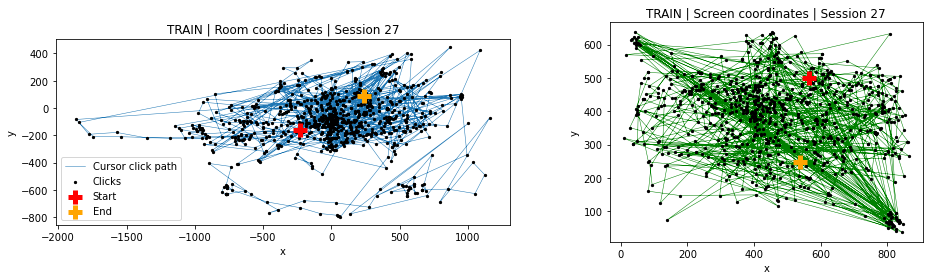

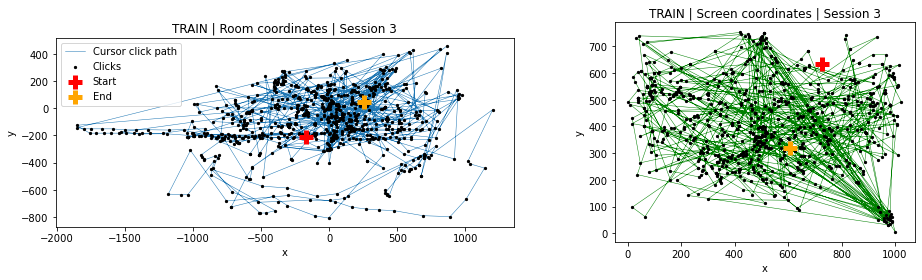

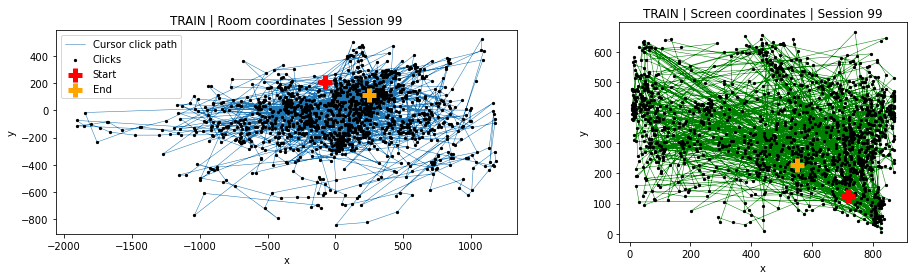

In [18]:
def plot_coordinates(i, set_name):
    df = train_df if set_name == 'TRAIN' else test_df
    session_ids = np.array(df['session_id'].unique())
    one_session = df[df['session_id'] == session_ids[i]]
    plt.figure(figsize=(14, 4))
    
    # Room coordinates
    coords = one_session[['room_coor_x', 'room_coor_y']].dropna().reset_index(drop=True)
    x = coords['room_coor_x']
    y = coords['room_coor_y']
    plt.subplot(1, 2, 1)
    plt.plot(x, y, zorder=0, lw=0.5)
    plt.scatter(x, y, s=5, color='black')
    plt.scatter(x[0], y[0], s=200, lw=5, color='red', marker='+')
    plt.scatter(x[-1:], y[-1:], s=200, lw=5, color='orange', marker='+')
    plt.legend(['Cursor click path', 'Clicks', 'Start', 'End'])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{set_name} | Room coordinates | Session {i}")
    
    # Screen coordinates
    coords = one_session[['screen_coor_x', 'screen_coor_y']]\
        .dropna().reset_index(drop=True)
    x = coords['screen_coor_x']
    y = coords['screen_coor_y']
    plt.subplot(1, 2, 2)
    plt.plot(x, y, zorder=0, lw=0.5, color='green')
    plt.scatter(x, y, s=5, color='black')
    plt.scatter(x[0], y[0], s=200, lw=5, color='red', marker='+')
    plt.scatter(x[-1:], y[-1:], s=200, lw=5, color='orange', marker='+')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{set_name} | Screen coordinates | Session {i}")
    
    plt.tight_layout()
    plt.show()

# Plot 3 session examples from the train set
for i in [27, 3, 99]:
    plot_coordinates(i, 'TRAIN')

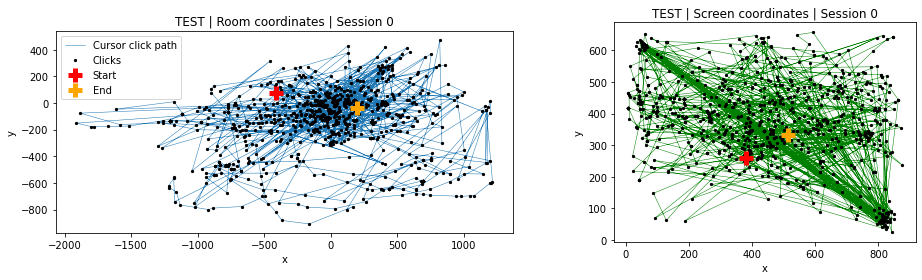

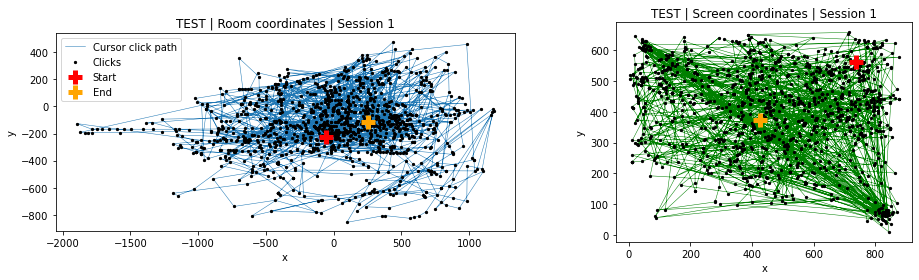

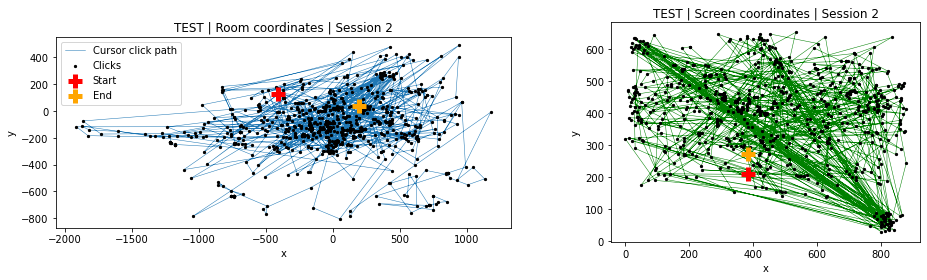

In [19]:
# Plot coordinates of all the sessions of the test set (only 3 sessions)
for i in range(3):
    plot_coordinates(i, 'TEST')

#### - Insights
- The clicking patterns across various sessions are alike. There are noticeable clusters of clicks in certain regions.
- An analysis of the screen coordinates reveals the presence of at least three potential button clusters located at the top-left, bottom-right, and top of the screen. The user repeatedly navigated between these clusters, resulting in a concentration of lines in the diagonal direction.
- These coordinates are probably a wealth of information that allows us to track the user's actions, making it valuable information for predictions.

## 💡 Labels
Let's see the distribution of the different classes.
- 0: incorrect answer to the question
- 1: correct answer to the question

In [20]:
classes_count = labels_df['correct'].value_counts()
print("Classes count:\n", classes_count, "\n")
print("Ratio:\n", classes_count / len(labels_df))
labels_df

Classes count:
 1    299271
0    124845
Name: correct, dtype: int64 

Ratio:
 1    0.705635
0    0.294365
Name: correct, dtype: float64


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1
...,...,...
424111,22100215342220508_q18,1
424112,22100215460321130_q18,1
424113,22100217104993650_q18,1
424114,22100219442786200_q18,1


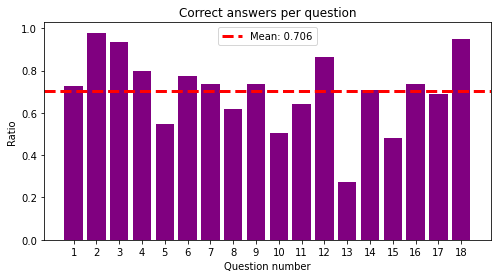

In [21]:
labels_df['question'] = labels_df['session_id'].apply(lambda x: int(x.split('_')[1][1:]))

# Calculate correct ratios
correct_ratios = []
for q in range(1, 19):
    tmp = labels_df[labels_df['question'] == q]['correct']
    ratio = tmp.sum() / len(tmp) 
    correct_ratios.append(ratio)

xrange = range(1, 19)
mean = np.mean(correct_ratios)
plt.figure(figsize=(8, 4))
plt.bar(x=xrange, height=correct_ratios, color='purple')
plt.axhline(mean, color='red', ls='--', lw=3)
plt.xticks(xrange)
plt.legend([f'Mean: {mean:.3f}'])
plt.title("Correct answers per question")
plt.xlabel("Question number")
plt.ylabel("Ratio")
plt.show()

#### -Insights
- About 70% of the answers are correct and 30% are incorrect.
- The dataset is slightly imbalanced.
- The labels only go up to level 18, even though the questions extend up to level 22 in the training set.

**Thank you for reading my EDA. If you have any suggestion, please let me know!**